In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_pickle("files/inst.dat")

### Set-up


In [4]:
# drop redundant cols

from functions.labels import *

label_dicts = {
    "tgt": tgt_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "efw": efw_labels,
    "pts": pts_labels,
    "p5d": p5d_labels,
    "wb_iq": wb_iq_labels,
    "wgi": wgi_labels,
    "controls": controls_labels,
}

keep_cols = ['country', 'year', 'iso_code_1','iso_code_2', 'region'] + [v for d in label_dicts.values() for v in d.keys()]
dropped = [c for c in df.columns if c not in keep_cols]
df = df[[c for c in df.columns if c in keep_cols]].copy()
print(f"Kept {len(df.columns)} cols, dropped {len(dropped)}")

Kept 141 cols, dropped 83


In [5]:
# create lagged target var, drop other target vars

from functions.utils import prep_target

df = prep_target(df)

In [6]:
# drop obs without target var

b_obs, b_cty = len(df), df["country"].nunique()
df = df.dropna(subset=["tgt_spread_lag"]).copy().reset_index(drop=True)
a_obs, a_cty = len(df), df["country"].nunique()

print(f"Kept {a_cty} countries, dropped {b_cty - a_cty}\nKept {a_obs:,} obs, dropped {(b_obs - a_obs):,}")

df.head()

Kept 72 countries, dropped 127
Kept 2,247 obs, dropped 10,356


,country,year,iso_code_1,iso_code_2,region,tgt_spread_lag,efw_economic_freedom_summary_index,efw_1a_government_consumption,efw_1b_transfers_and_subsidies,efw_1c_government_investment,...,wb_iq_spi_pil3,wb_iq_spi_pil4,wb_iq_spi_pil5,wb_iq_wef_cust_xq,wb_iq_wef_port_xq,wb_fx_dep_yoy,wb_gc_dod_totl_gd_zs_chg,wb_gdp_growth_vol3y,wb_infl_vol3y,wb_ca_bal_ma3
0,Angola,2012,AO,AGO,Middle Africa,5.845834,5.25,1.779412,8.403203,7.025750,...,68.15000,NaN,NaN,NaN,NaN,0.016190,NaN,2.699816,2.191443,10.490228
1,Angola,2013,AO,AGO,Middle Africa,5.625834,4.95,1.017647,8.253906,1.595059,...,65.15000,NaN,NaN,118.8,156.6,0.010942,NaN,2.606835,2.403236,9.556112
2,Angola,2014,AO,AGO,Middle Africa,5.634167,4.86,3.297059,8.010978,2.142542,...,66.41250,NaN,NaN,88.2,132.3,0.018316,NaN,2.110394,1.498759,4.735818
3,Angola,2015,AO,AGO,Middle Africa,5.910000,5.45,4.782353,8.886739,10.000000,...,67.33125,NaN,NaN,NaN,NaN,0.199949,NaN,2.278612,1.071184,-2.651053
4,Angola,2016,AO,AGO,Middle Africa,5.253333,5.18,5.923529,9.370572,10.000000,...,70.44375,30.566667,40.0,NaN,NaN,0.309772,NaN,3.702756,12.960542,-6.651760


Median year for 75% coverage: 2015


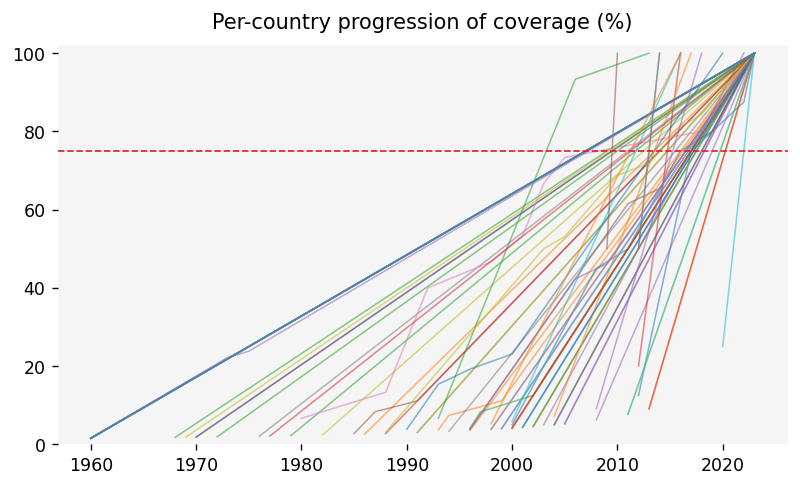

In [7]:
# identify split year as year when countries have c. 75% behind them

dff = df.dropna(subset=["tgt_spread_lag"]).sort_values(["country", "year"])
dff["cum_share"] = (dff.groupby("country").cumcount() + 1) / dff.groupby("country")["year"].transform("count")
cross_years = dff.loc[dff["cum_share"] >= 0.75].groupby("country")["year"].min()
print(f"Median year for 75% coverage: {int(cross_years.median())}")

from functions.plot import coverage_progression

coverage_progression(df)

In [8]:
# forward-fill

from functions.fill import fill

df_ff = fill(df)

# remove stale observations (fills from 3+ years)

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
ffilled_count = 0
removed_count = 0

for fcol in fcols:
    base = fcol[:-2]
    if base in df_ff.columns:
        m_ffilled = (df_ff[fcol] > 0) & (df_ff[fcol] <= 3) & df_ff[base].notna()
        m_removed = (df_ff[fcol] > 3) & df_ff[base].notna()
        ffilled_count += m_ffilled.sum()
        removed_count += m_removed.sum()
        df_ff.loc[df_ff[fcol] > 3, base] = np.nan

# fills summary

print(f"\n{removed_count:,} f-filled values removed due to staleness (3+ years), {ffilled_count:,} f-filled values remain")

from functions.fill import save_nulls_share

df_ff = save_nulls_share(df_ff, 'ffill')
print(f"Average observation null share decreased from {df_ff["nulls_init"].mean()*100:.0f} to {df_ff["nulls_ffill"].mean()*100:.0f} percent")
df_ff = df_ff.drop(columns=["nulls_init", "nulls_ffill"])

F-filling Angola values
F-filling Armenia values
F-filling Australia values
F-filling Austria values
F-filling Bangladesh values
F-filling Belgium values
F-filling Botswana values
F-filling Brazil values
F-filling Bulgaria values
F-filling Canada values
F-filling Chile values
F-filling China values
F-filling Colombia values
F-filling Costa Rica values
F-filling Croatia values
F-filling Cyprus values
F-filling Czechia values
F-filling Côte d'Ivoire values
F-filling Denmark values
F-filling Estonia values
F-filling Fiji values
F-filling Finland values
F-filling France values
F-filling Germany values
F-filling Ghana values
F-filling Greece values
F-filling Hungary values
F-filling Iceland values
F-filling India values
F-filling Indonesia values
F-filling Ireland values
F-filling Israel values
F-filling Italy values
F-filling Japan values
F-filling Kyrgyzstan values
F-filling Latvia values
F-filling Lithuania values
F-filling Luxembourg values
F-filling Malaysia values
F-filling Malta valu

In [9]:
# save dataset

df_ff.to_pickle("files/df_ff.dat")

In [10]:
# load

df_ff = pd.read_pickle("files/df_ff.dat")

# drop _f metadata cols

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
df_ff = df_ff.drop(columns=fcols)

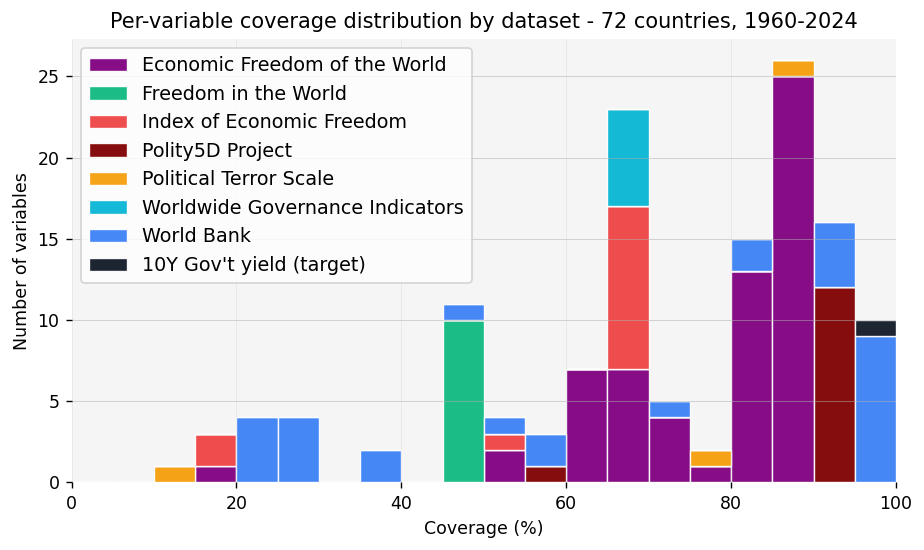

Removed 14 columns with less than 40% coverage, 127 remain
Removed ['efw_5diii_distorton_of_the_business_environment', 'ief_judicial_effectiveness', 'ief_fiscal_health', 'pts_pts_h', 'wb_iq_sci_mthd', 'wb_iq_sci_ovrl', 'wb_iq_sci_prdc', 'wb_iq_sci_srce', 'wb_iq_spi_ovrl', 'wb_iq_spi_pil2', 'wb_iq_spi_pil4', 'wb_iq_spi_pil5', 'wb_iq_wef_cust_xq', 'wb_iq_wef_port_xq']


In [11]:
# show columns coverage

from functions.plot import coverage_per_variable

coverage_per_variable(df_ff)

# drop columns with less than 40% coverage

coverage = df_ff.notna().mean()
to_drop = coverage[coverage < 0.4].index
df_ff = df_ff.drop(columns=to_drop)
print(f"Removed {len(to_drop)} columns with less than 40% coverage, {df_ff.shape[1]} remain")
print("Removed", to_drop.tolist() )

In [12]:
# create three datasets

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]

macro_iq = df_ff.copy()
macro_only = df_ff[id_cols + [c for c in df_ff.columns if c.startswith("wb_") and not c.startswith("wb_iq_")]]
iq_only = df_ff[id_cols + [c for c in df_ff.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in id_cols))]]

# split into test and train

split_year = 2015
datasets = {"MACRO_ONLY": macro_only, "IQ_ONLY": iq_only, "MACRO+IQ": macro_iq}

macro_train, macro_test, iq_train, iq_test, macro_iq_train, macro_iq_test = [
    part
    for d in datasets.values()
    for part in (d[d["year"] <= split_year].copy(), d[d["year"] > split_year].copy())
]

# show shapes

for name, (train, test) in zip(
    datasets.keys(),
    [(macro_train, macro_test), (iq_train, iq_test), (macro_iq_train, macro_iq_test)]
):
    print(f"{name:<10} → train: {train.shape}, test: {test.shape}")

MACRO_ONLY → train: (1762, 23), test: (485, 23)
IQ_ONLY    → train: (1762, 109), test: (485, 109)
MACRO+IQ   → train: (1762, 127), test: (485, 127)


In [13]:
from functions.utils import standardise

# standardise

macro_train_s, macro_test_s = standardise(macro_train, macro_test)
iq_train_s, iq_test_s = standardise(iq_train, iq_test)
macro_iq_train_s, macro_iq_test_s = standardise(macro_iq_train, macro_iq_test)

# check means and std. devs

from functions.utils import check_standardisation

check_standardisation(macro_train_s, "MACRO train")
check_standardisation(macro_test_s,  "MACRO test")
check_standardisation(iq_train_s,    "IQ train")
check_standardisation(iq_test_s,    "IQ test")
check_standardisation(macro_iq_train_s, "MACRO+IQ train")
check_standardisation(macro_iq_test_s, "MACRO+IQ test")

# run zero leakage checks

from functions.utils import assert_zero_leakage

assert_zero_leakage(macro_train, macro_test, macro_train_s, macro_test_s, "MACRO", 2015)
assert_zero_leakage(iq_train, iq_test, iq_train_s, iq_test_s, "IQ", 2015)
assert_zero_leakage(macro_iq_train, macro_iq_test, macro_iq_train_s, macro_iq_test_s, "MACRO+IQ", 2015)

— MACRO train —
Mean range: -0.0 → -0.0
Std  range: 1.0 → 1.0

— MACRO test —
Mean range: -0.29 → 0.591
Std  range: 0.038 → 2.891

— IQ train —
Mean range: -0.0 → -0.0
Std  range: 1.0 → 1.0

— IQ test —
Mean range: -0.79 → 4.778
Std  range: 0.066 → 2.572

— MACRO+IQ train —
Mean range: -0.0 → -0.0
Std  range: 1.0 → 1.0

— MACRO+IQ test —
Mean range: -0.79 → 4.778
Std  range: 0.038 → 2.891



### Models and tuning
- Implement Ridge, Lasso, and Elastic Net models (α = 0.25, 0.5, 0.75).
- Show MSE loss
- Define a log-spaced λ grid (~50–100 values).
- Run expanding or rolling, time-respecting cross-validation (train ≤ t → validate t + 1).
- Select the λ that minimises CV error for each model and specification (IQ-only, Macro-only, IQ + Macro, Mean reversion benchmark).
- Store tuned models and summary of CV results.

### Evaluation
- Generate out-of-sample predictions on the held-out test period.
- Compute and compare out-of-sample R² and RMSE for all specifications.
- Plot coefficient paths across λ and identify the top-10 absolute coefficients for the selected model.
- Summarise main quantitative findings (how much IQ + Macro improves vs benchmarks, key predictors).

### Final models
- Refit each selected model on the full training window using its chosen λ.
- Save final fitted models and coefficients.
- Produce a concise 2-to-3-page mini-note describing motivation, data, method, main results, and takeaways.

### Extensions and robustness
- Re-estimate the best model using a log(1 + spread) target to test stability to skewness.
- Re-estimate the best model by excluding the staleness filter and down-weighting _f>0 cols
- Apply 1% winsorisation to predictors to reduce the influence of outliers; re-run baseline model.
- Compare changes in out-of-sample R² and RMSE to baseline.
- Write 1-paragraph summary on robustness of results (e.g., “findings remain stable under log-transform and mild trimming”).